In [1]:
!ls

'20150525_123348 - Copy.jpg'   pose.caffemodel	 pose.prototxt	 Untitled.ipynb
 human_pose.py		       pose.plan	 __pycache__


In [2]:
from torch.utils.cpp_extension import load

find_peaks = load(name='find_peaks', sources=['find_peaks.cpp'])


In [42]:
refine_peaks = load(name='refine_peaks', sources=['refine_peaks.cpp'])

In [259]:
paf_cost_graph = load(name='paf_cost_graph', sources=['paf_cost_graph.cpp'])

In [4]:
import torch

In [5]:
import torch2trt

In [6]:
import tensorrt as trt

In [7]:
logger = trt.Logger(trt.Logger.INFO)
runtime = trt.Runtime(logger)

In [8]:
with open('pose.plan', 'rb') as f:
    engine = runtime.deserialize_cuda_engine(f.read())
    

In [16]:
engine.get_binding_name(2)

'Mconv7_stage6_L2'

In [17]:
model = torch2trt.TRTModule(engine, ['image'], ['Mconv7_stage6_L1', 'Mconv7_stage6_L2'])

In [7]:
import PIL.Image

image = PIL.Image.open('20150525_123348 - Copy.jpg').resize((368, 368)).rotate(270)

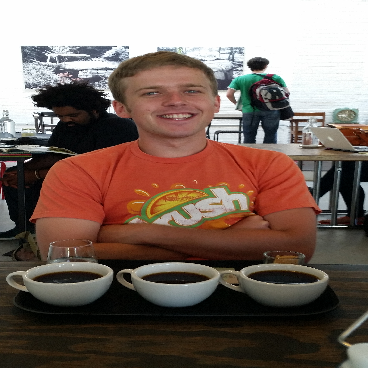

In [8]:
image

In [47]:
inp = torchvision.transforms.ToTensor()(image).cuda().float()[None, ...] - 0.5

In [48]:
paf, cmap = model(inp)

In [64]:
torch.save(paf, 'paf.pt')

In [65]:
torch.save(cmap, 'cmap.pt')

In [9]:
paf = torch.load('paf.pt')
cmap = torch.load('cmap.pt')

In [11]:
cmap = cmap.cpu().float()
paf = paf.cpu().float()

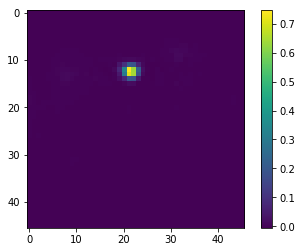

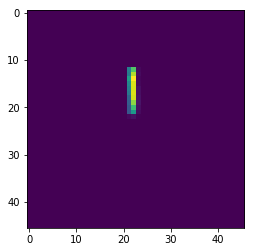

In [122]:
import matplotlib.pyplot as plt

plt.imshow(cmap[0][0].detach().cpu().numpy())
plt.colorbar()
plt.show()
plt.imshow((paf[0][28:30]**2).sum(0).detach().cpu().numpy())
plt.show()

In [45]:
counts, peaks = find_peaks.forward(cmap, 0.1, 3, 100)

In [59]:
import time

t0 = time.time()

for i in range(100):
    counts, peaks = find_peaks.forward(cmap, 0.1, 3, 100)
    refined_peaks = refine_peaks.forward(counts, peaks, cmap, 3)

t1 = time.time()
print((t1 - t0) / 100.0)

0.0009913444519042969


In [44]:
print(peaks[0][1][0])
print(refined_peaks[0][1][0])

tensor([ 9, 32], dtype=torch.int32)
tensor([0.2114, 0.7020])


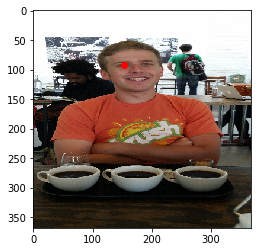

In [141]:
peak = refined_peaks[0][14][0]
plt.imshow(image)
plt.plot(peak[1] * 368.0, peak[0] * 368, 'ro')
plt.show()

In [ ]:
  config.part_names = {
    "NOSE", // 0
    "NECK", // 1
    "RSHOULDER", // 2
    "RELBOW", // 3
    "RWRIST", // 4
    "LSHOULDER", // 5
    "LELBOW",// 6
    "LWRIST",// 7
    "RHIP",// 8
    "RKNEE",// 9
    "RANKLE",// 10
    "LHIP",// 11
    "LKNEE", // 12
    "LANKLE", // 13
    "REYE", // 14
    "LEYE", // 15
    "REAR", // 16
    "LEAR", // 17
  };

  config.topology = {
    { config.partIndex("NECK"), config.partIndex("RHIP") }, // 0
    { config.partIndex("RHIP"), config.partIndex("RKNEE") }, // 1
    { config.partIndex("RKNEE"), config.partIndex("RANKLE") }, // 2
    { config.partIndex("NECK"), config.partIndex("LHIP") }, // 2
    { config.partIndex("LHIP"), config.partIndex("LKNEE") }, // 3
    { config.partIndex("LKNEE"), config.partIndex("LANKLE") }, // 4
    { config.partIndex("NECK"), config.partIndex("RSHOULDER") }, // 5
    { config.partIndex("RSHOULDER"), config.partIndex("RELBOW") }, // 6
    { config.partIndex("RELBOW"), config.partIndex("RWRIST") }, //7
    { config.partIndex("RSHOULDER"), config.partIndex("REAR") }, // 8
    { config.partIndex("NECK"), config.partIndex("LSHOULDER") }, // 9
    { config.partIndex("LSHOULDER"), config.partIndex("LELBOW") }, // 10
    { config.partIndex("LELBOW"), config.partIndex("LWRIST") }, // 11
    { config.partIndex("LSHOULDER"), config.partIndex("LEAR") }, // 12
    { config.partIndex("NECK"), config.partIndex("NOSE") }, // 13
    { config.partIndex("NOSE"), config.partIndex("REYE") }, // 14
    { config.partIndex("NOSE"), config.partIndex("LEYE") }, // 15
    { config.partIndex("REYE"), config.partIndex("REAR") }, // 16
    { config.partIndex("LEYE"), config.partIndex("LEAR") }, // 17

In [91]:
14*2 + 0

28

// paf = Nx(2*K)xHxW
// topology = Kx4 --> (paf_i_idx, paf_j_idx, cmap_a_idx, cmap_b_idx)
// counts = NxC
// peaks = NxCxMx2
// cost_graph = NxKxMxM

In [169]:
topology = torch.Tensor([[37, 36, 15, 17]] + [[29, 28, 1, 0]]*18).int()

In [106]:
topology.shape

torch.Size([19, 4])

In [134]:
paf_big = torch.nn.functional.interpolate(paf, (368, 368), mode='bicubic')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [162]:
refined_peaks_b = refined_peaks - 0.5/46.0

In [230]:
cost_graph = paf_cost_graph.forward(paf_big, topology, counts, refined_peaks, 3)

In [209]:
topology[0]

tensor([0, 1, 0, 1], dtype=torch.int32)

In [354]:
paf = torch.Tensor([[
    [
        [1.0, 0.0, 0.0, 0.0],
        [1.0, 1.0, 0.0, 0.0],
        [1.0, 0.0, 1.0, 0.0],
        [1.0, 0.0, 0.0, 1.0]
    ],
    [
        [1.0, 1.0, 1.0, 1.0],
        [0.0, 1.0, 0.0, 0.0],
        [0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 1.0]
    ]
]])
topology = torch.Tensor([[0, 1, 0, 1]]).int()
peaks = torch.zeros((1, 2, 2, 2)).float()
peaks[0][0][0] = torch.Tensor([0.0, 0.0])
peaks[0][1][0] = torch.Tensor([0.0, 1.0])
peaks[0][1][1] = torch.Tensor([1.0, 1.0])
counts = torch.Tensor([[1, 2]]).int()

In [333]:
paf_cost_graph = load(name='paf_cost_graph', sources=['paf_cost_graph.cpp'])

In [355]:
cost_graph = paf_cost_graph.forward(paf, topology, counts, peaks, 10)

In [356]:
cost_graph[0][0]

tensor([[1.0000, 1.4142],
        [0.0000, 0.0000]])

In [174]:
paf.shape

torch.Size([1, 2, 4, 4])

In [171]:
cost_graph[0][0]

tensor([[-0.0451,  0.1997,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])